In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# initialisation Environment class
class Env:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.arm_means = [0.5 for _ in range(self.n_arms)]
        
    def start_step(self, step=None):
        rewards = [np.random.uniform() for _ in range(self.n_arms)]
        return rewards
    
    @property
    def best_arm(self):
        return  self.arm_means.index(max(self.arm_means))


In [4]:
class BernoulliEnv(Env):
    """
    Bernoulli Environment
    """
    def __init__(self, params):
        super().__init__(len(params))
        self.params = params
        self.arm_means = [p for p in params]
        
    def start_step(self, step=None):
        rewards = [np.random.binomial(n=1, p=p) 
                   for idx, p in zip(range(self.n_arms), self.params)]
        return rewards

In [5]:
class UnifEnv(Env):
    """
    Uniform Environment
    """
    def __init__(self, params):
        super().__init__(len(params))
        self.params = params
        self.arm_means = [p/2 for p in params]
        
    def start_step(self, step=None):
        rewards = [np.random.uniform(high=self.params[idx]) 
                   for idx in range(self.n_arms)]
        return rewards

In [6]:
class BetaEnv(Env):
    """
    Beta Environment
    """
    def __init__(self, params):
        super().__init__(len(params))
        # params = [alpha, beta]
        self.params = params
        self.arm_means = [p[0] / (p[0] + p[1]) for p in params]
        
    def start_step(self, step=None):
        rewards = [np.random.beta(self.params[idx][0], self.params[idx][1]) 
                   for idx in range(self.n_arms)]
        return rewards

In [7]:
# initialisation Player class
class BasePlayer:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        
    def take_action(self):
        return np.random.randint(low=0, high=self.n_arms)
        
    def advance(self, action, reward):
        pass

In [8]:
class ThompsonPlayer(BasePlayer):
    """
    Thompson algorithm
    """
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.paretos = [[0.01, 1] for _ in range(self.n_arms)]
        
    def take_action(self):
        arms_rpr = [(np.random.pareto(alpha, size=1) + 1) * x_m 
                    for x_m, alpha in self.paretos]
        best_arm = arms_rpr.index(max(arms_rpr))
        return best_arm
        
    def advance(self, action, reward):
        self.paretos[action][0] = max(self.paretos[action][0], reward)
        self.paretos[action][1] += 1 
        

In [9]:
class UCBPlayer(BasePlayer):
    """
    UCB algorithm
    """
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.arm_rpr = [{"cum_rewards":0, "draws": 0} 
                        for _ in range(self.n_arms)]
        self.total_rounds = 0
        self.UCBs = []
                
    def take_action(self):
        if self.total_rounds < self.n_arms:
            return self.total_rounds
        
        cst = np.sqrt(2*np.log(self.total_rounds))
        arms_rpr = [arm["cum_rewards"]/arm["draws"] + cst/np.sqrt(arm["draws"])
                   for arm in self.arm_rpr]
        self.UCBs.append(arms_rpr)
        best_arm = arms_rpr.index(max(arms_rpr))
        return best_arm
        
    def advance(self, action, reward):
        self.total_rounds += 1
        self.arm_rpr[action]["cum_rewards"] += reward
        self.arm_rpr[action]["draws"] += 1

In [10]:
# https://jmlr.csail.mit.edu/papers/volume7/evendar06a/evendar06a.pdf
class AAEPlayer(BasePlayer):
    """
    AAE algorithm
    """
    def __init__(self, n_arms, confidence):
        self.n_arms = n_arms
        self.confidence = confidence
        self.arm_rpr = [{"cum_rewards":0, "draws": 0} 
                        for _ in range(self.n_arms)]
        self.total_rounds = 0
        self.current_step = 0
        self.active_arms = [arm for arm in range(self.n_arms)]
        
    def take_action(self):
        if len(self.active_arms) == 1:
            return self.active_arms[0]
        elif self.current_step < len(self.active_arms):
            return self.active_arms[self.current_step]
        else:
            print('Error in taking action')
        
    def advance(self, action, reward):
        self.total_rounds += 1 
        self.arm_rpr[action]["cum_rewards"] += reward
        self.arm_rpr[action]["draws"] += 1
        if len(self.active_arms) == 1:
            pass
        elif self.current_step == len(self.active_arms) - 1:
            self.current_step = 0
            probas = [self.arm_rpr[arm]["cum_rewards"]/self.arm_rpr[arm]["draws"]
                      for arm in range(self.n_arms)]
            p_max = probas.index(max(probas))
            alpha = np.sqrt(np.log((4*self.n_arms*self.total_rounds**2)\
                                   /self.confidence)/self.total_rounds)
            self.active_arms = [arm for arm in self.active_arms 
                                if p_max - probas[arm] < 2*alpha]
            # in case all arms are eliminated at once, we keep the best
            if len(self.active_arms)==0:
                self.active_arms = [p_max]
        else:
            self.current_step += 1


In [11]:
class BARBARPlayer(BasePlayer):
    """
    BARBAR algorithm
    """
        
    def __init__(self, n_arms, confidence, nb_rounds):

        self.n_arms = n_arms
        self.confidence = confidence
        self.nb_rounds = nb_rounds
        
        self.delta = [1 for _ in range(self.n_arms)]
        self._lambda = 1024*np.log((8*self.n_arms/self.confidence)\
                                   *np.log2(self.nb_rounds))
        self.n = [self._lambda/(d**2) for d in self.delta]
        self.total_n = sum(self.n)
        self.T_m = self.total_n
        self.rewards = list()
        self.optimum_reward = 0
        self.total_reward_epoch = [0 for _ in range(n_arms)]
        self.epoch = 1
        self.current_step = 1

        
    def take_action(self):
        idx = 0
        cum_probas = self.n[idx]
        u = np.random.uniform()

        while u > cum_probas/self.total_n:
            #print(u)
            #print(cum_probas/self.total_n)
            idx += 1
            cum_probas += self.n[idx]
        
        best_arm = idx
        return best_arm
        
    def advance(self, action, reward):
        self.total_reward_epoch[action] += reward
        if self.current_step >= self.T_m:
            #print('length of current epoch', self.total_n)
            self.rewards = [reward/n
                            for reward, n 
                            in zip(self.total_reward_epoch, self.n)]
            #print('mean reward by arm during current epoch', self.rewards)
            self.optimum_reward = max([reward - delta/16 
                                       for reward, delta 
                                       in zip(self.rewards, self.delta)])
            #print('optimum reward', self.optimum_reward)
            self.delta = [max(1/(2**self.epoch), self.optimum_reward - reward) 
                          for reward in self.rewards]
            #print('delta', self.delta)
            self.n = [self._lambda/(d**2) for d in self.delta]
            #print('n', self.n)
            self.total_n = sum(self.n)
            #print('length of next epoch', self.total_n)
            self.T_m += self.total_n
            self.epoch += 1
            self.total_reward_epoch = [0 for _ in range(self.n_arms)]
        self.current_step += 1

In [12]:
# initialisation Adversary class
class Adversary:  
    def __init__(self, frequency=.4, bound=None):
        self.frequency = frequency
        # bounded corruption : https://arxiv.org/pdf/1807.07623.pdf
        # ce n'est pas exactement la bonne implémentation du bound
        self.bound = bound 
        self._validate_init()
        
    def _validate_init(self):
        # check self._corrupt_rewards is implemented
        #self._corrupt_rewards([.1, .1, .1])
        assert isinstance(self.frequency, float) and 0 <= self.frequency <= 1
            
    def _corrupt_rewards(self, rewards):
        raise NotImplementedError('You MUST implement _corrupt_rewards')
    
    def corrupt_rewards(self, rewards):
        if np.random.uniform() > self.frequency:
            return rewards
        
        corrupted_rewards = self._corrupt_rewards(rewards)
        
        if self.bound==None:
            return corrupted_rewards
        else:
            corrupted_rewards = [corr if abs(corr-true) < self.bound else true - self.bound
                                 for corr, true in zip(corrupted_rewards, rewards)]
        return corrupted_rewards

In [13]:
class DummyAdversary(Adversary):
    """
    Dummy adversary: no corruption
    """
    def _corrupt_rewards(self, rewards):
        return rewards

In [14]:
class UnifAdv(Adversary):
    """
    Uniform adversary: corrupt by constant amount on each arm.
    amount is generated using a Uniform distribution
    """
    def __init__(self, corruption=0.5, frequency=.5, bound=None):
        self._check_args(corruption)
        self.corruption = corruption    
        super().__init__(frequency, bound)
        
    def _check_args(self, corruption):
        if not isinstance(corruption, float):
            raise TypeError(f'corruption should be float, got {corruption}')
        if not corruption > 0:
            raise ValueError(f'corruption should be positive, got {corruption}')
        if not corruption <= 1:
            raise ValueError(f'corruption should be <= 1, got {corruption}')
            
    def _corrupt_rewards(self, rewards):
        corruption = np.random.uniform(low=0, high=self.corruption)
        corrupted_rewards = [max(0, reward - corruption)
                             for reward in rewards]
        
        return corrupted_rewards

In [15]:
# corrupt max current reward
class MaxCurrentAdv(Adversary):
    """
    MaxCurrent adversary: only corrupt the current best reward
    """
    def __init__(self, corruption=0.2, frequency=.5, bound=None):
        self._check_args(corruption)
        self.corruption = corruption   
        super().__init__(frequency, bound)
            
    def _check_args(self, corruption):
        if not isinstance(corruption, float):
            raise TypeError(f'corruption should be float, got {corruption}')
        if not corruption > 0:
            raise ValueError(f'corruption should be positive, got {corruption}')
        if not corruption <= 1:
            raise ValueError(f'corruption should be <= 1, got {corruption}')
            
    def _corrupt_rewards(self, rewards):
        corrupted_rewards = [reward 
                             if reward!=max(rewards)
                             else max(0,reward-self.corruption)
                             for reward in rewards]
        
        return corrupted_rewards

In [16]:
# compute regrets
def compute_strategy_regret(number_of_rounds, selected_arms, arm_means):
    means_per_round = [arm_means[selected_arm] for selected_arm in selected_arms]

    regret = number_of_rounds * max(arm_means)
    regret = regret - sum(means_per_round)

    return regret

def compute_instance_worst_possible_regret(number_rounds, arm_means):
    worst_arm_index = arm_means.index(min(arm_means))

    worst_possible_selections = [worst_arm_index for i in range(number_rounds)]

    worst_possible_regret = compute_strategy_regret(
        number_rounds, worst_possible_selections, arm_means
    )

    return worst_possible_regret

def compute_immediate_regrets(actions, all_rewards, best_arm_mean):
    flattened_rewards = [rewards[action] 
               for action, rewards in zip(actions, all_rewards)]

    best_arm_means = np.array([best_arm_mean for _ in range(len(actions))]) 
    cumulative_mean = np.cumsum(flattened_rewards)/np.arange(1, len(actions)+1)
    
    immediate_regrets = best_arm_means - cumulative_mean
    
    return immediate_regrets

In [17]:
# spécial Thompson
def plot_posteriors(beta_priors, ax=None, title=None):
    # fig = plt.figure(figsize=(12.5, 10))

    x = np.linspace(0.001, 1, 150)
    for i, (alpha, beta) in enumerate(beta_priors):
        # color = assets[i]
        y = stats.beta.rvs(alpha, beta, size=10000)
        """
        lines = sns.lineplot(
            x, y, label="%s (%.1f,%.1f)" % (color, alpha, beta), color=color, ax=ax
        )
        """
        lines = sns.lineplot(x, y, label="(%.1f,%.1f)" % (alpha, beta), ax=ax)
        # lines = sns.distplot(y)
        # plt.fill_between(x, 0, y, alpha=0.2, color=color)
        if title:
            plt.title(title)
        plt.autoscale(tight=True)
    plt.legend(title=r"$\alpha, \beta$ - beta_priors")
    return plt



def plot_thompson_samping_beta_parameters_evolution():
    fig = plt.figure(figsize=(40, 60))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    cnt = 1
    for i in range(0, 30, 2):
        ax = fig.add_subplot(8, 4, cnt)
        g = plot_posteriors(*data[i][1:], ax, "after " + str(i) + " runs")
        cnt += 1
    plt.show()

In [18]:
# spécial UCB
def plot_upper_confidence_bounds_decrease(upper_confidence_bounds, figsize=(17, 15)):

    plt.figure(figsize=figsize)
    for i in range(upper_confidence_bounds.shape[0]):
        plt.plot(upper_confidence_bounds[i], label="Arm {}".format(i))
    plt.legend(prop={"size": 17})
    plt.xlabel("Number of Selections")
    plt.ylabel("Upper Confidence Bound")


In [19]:
# plots
def plot_immediate_regrets(list_of_immediate_regrets, labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(list_of_immediate_regrets)):
        plt.plot(list_of_immediate_regrets[i], label=labels[i])
    plt.legend()
    plt.xlabel("Number of rounds")
    plt.ylabel("Regret")

def plot_arm_selection_histogram(selected_arms):
    plt.figure(figsize=(13, 9))
    plt.hist(selected_arms)
    plt.xlabel("Arms")
    plt.ylabel("Number of Selections")

In [20]:
# compute upper bound
def upper_bound(env, player, res, nb_rounds):
    admissible_players = [AAEPlayer, BARBARPlayer, UCBPlayer]
    if type(player) not in admissible_players:
        raise TypeError(f'player should be in {admissible_players}, got {type(player)}')
        
    if type(player)==BARBARPlayer:
        deltas = [env.arm_means[env.best_arm] - env.arm_means[i]
                  for i in range(env.n_arms) if i != env.best_arm ]
        inv_deltas = [1/d for d in deltas]
        bound = (res["corruption_level"]*env.n_arms + 
                 np.log(nb_rounds)*
                 np.log(env.n_arms*np.log(nb_rounds)/player.confidence)*
                 sum(inv_deltas))
    
    elif type(player)==UCBPlayer:
        print(f'not yet implemented for {type(player)}')
        bound = -1
        
    elif type(player)==AAEPlayer:
        print(f'not yet implemented for {type(player)}')
        bound = -1
    
    return bound

In [21]:
# main loop
def main_loop(env, player, adversary, nb_rounds):
    all_true_rewards = list()
    all_corrupted_rewards = list()
    all_actions = list()
    corruption = 0
    
    for step in range(nb_rounds):
        true_rewards = env.start_step(step)
        all_true_rewards.append(true_rewards)
        corrupted_rewards = adversary.corrupt_rewards(true_rewards)

        # Sanity check, corrupted rewards should still be in [0, 1]
        assert all(1 >= r >= 0 for r in corrupted_rewards), corrupted_rewards
        
        all_corrupted_rewards.append(corrupted_rewards)
        
        action = player.take_action()
        all_actions.append(action)
        player.advance(action, corrupted_rewards[action])
        
        corruption += max(abs(true_reward - corrupted_reward) 
                          for true_reward, corrupted_reward 
                          in zip(true_rewards, corrupted_rewards))
        
    return {
        "all_true_rewards": all_true_rewards,
        "all_corrupted_rewards" : all_corrupted_rewards,
        "all_actions": all_actions,
        "corruption_level": corruption
    }

In [22]:
%%time

# No adversary
# BARBAR player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
no_adversary = DummyAdversary()
res_barbar_no_corr = list()
bound_barbar_no_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = BARBARPlayer(env.n_arms, .05, i)
    res = main_loop(env, player, no_adversary, i)
    res_barbar_no_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))
    bound_barbar_no_corr.append(
        upper_bound(env, player, res, i))

CPU times: user 42.6 s, sys: 661 ms, total: 43.2 s
Wall time: 50.4 s


In [36]:
%%time

# No adversary
# UCB player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
no_adversary = DummyAdversary()
res_ucb_no_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = UCBPlayer(env.n_arms)
    res = main_loop(env, player, no_adversary, i)
    res_ucb_no_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))

CPU times: user 55.4 s, sys: 437 ms, total: 55.8 s
Wall time: 57.7 s


Text(0.5, 1.0, 'No corruption')

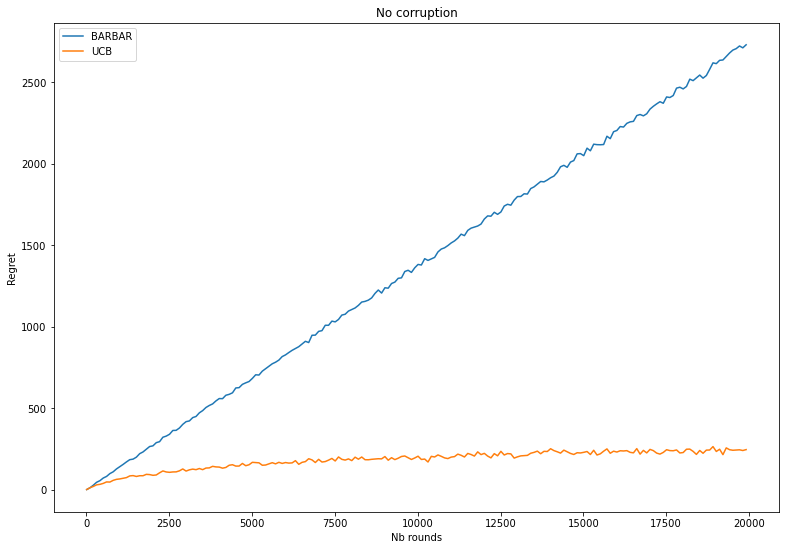

In [37]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_no_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_no_corr)
plt.legend(['BARBAR', 'UCB'], fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("No corruption")

In [38]:
%%time

# Unif adversary
# UCB player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
unif_adversary = UnifAdv(corruption=.5, frequency=.7)
res_ucb_unif_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = UCBPlayer(env.n_arms)
    res = main_loop(env, player, unif_adversary, i)
    res_ucb_unif_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))

CPU times: user 1min 2s, sys: 445 ms, total: 1min 2s
Wall time: 1min 4s


Text(0.5, 1.0, 'UCB')

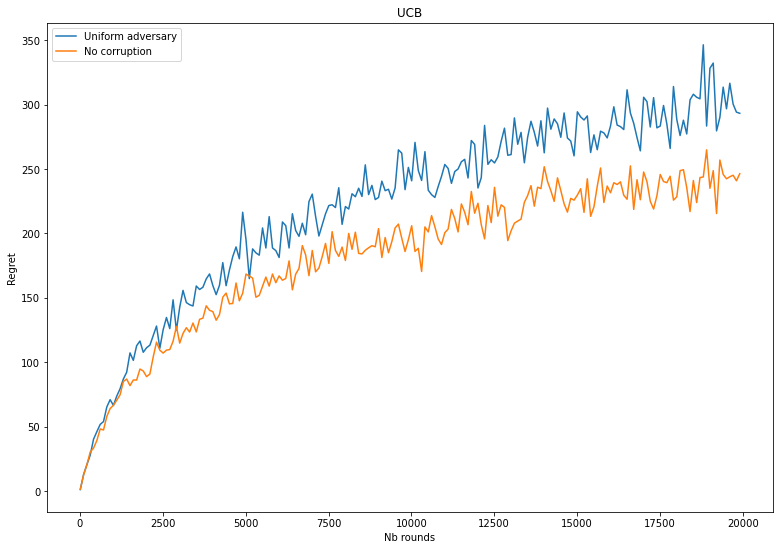

In [39]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_unif_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_no_corr)
plt.legend(['Uniform adversary', 'No corruption'], fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("UCB")

In [40]:
%%time

# Unif adversary
# BARBAR player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
unif_adversary = UnifAdv(corruption=.5, frequency=.7)
res_barbar_unif_corr = list()
bound_barbar_unif_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = BARBARPlayer(env.n_arms, .05, i)
    res = main_loop(env, player, unif_adversary, i)
    res_barbar_unif_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))
    bound_barbar_unif_corr.append(
        upper_bound(env, player, res, i))

CPU times: user 45.4 s, sys: 351 ms, total: 45.8 s
Wall time: 47.6 s


Text(0.5, 1.0, 'BARBAR')

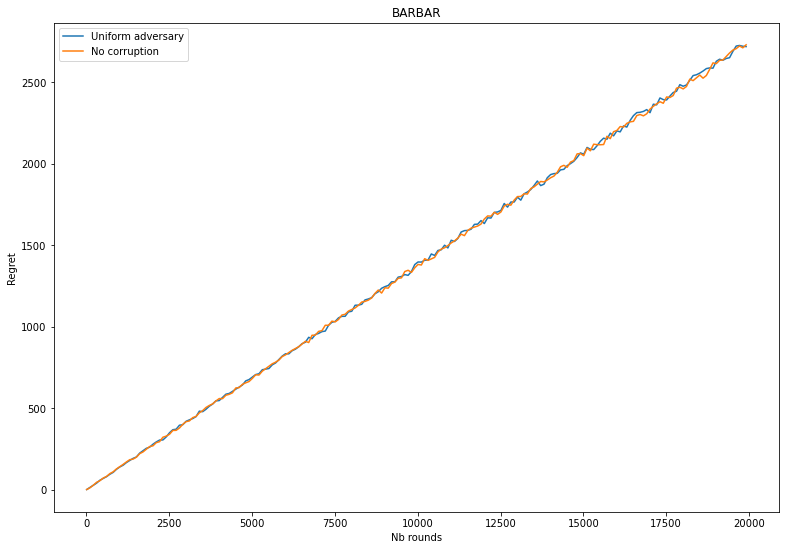

In [41]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_unif_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_no_corr)
plt.legend(['Uniform adversary', 'No corruption'], fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("BARBAR")

In [42]:
%%time

# Max Current adversary
# BARBAR player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
max_adversary = MaxCurrentAdv(corruption=.3, frequency=.7)
res_barbar_max_corr = list()
bound_barbar_max_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = BARBARPlayer(env.n_arms, .05, i)
    res = main_loop(env, player, max_adversary, i)
    res_barbar_max_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))
    bound_barbar_max_corr.append(
        upper_bound(env, player, res, i))

CPU times: user 43 s, sys: 409 ms, total: 43.4 s
Wall time: 45.6 s


Text(0.5, 1.0, 'BARBAR')

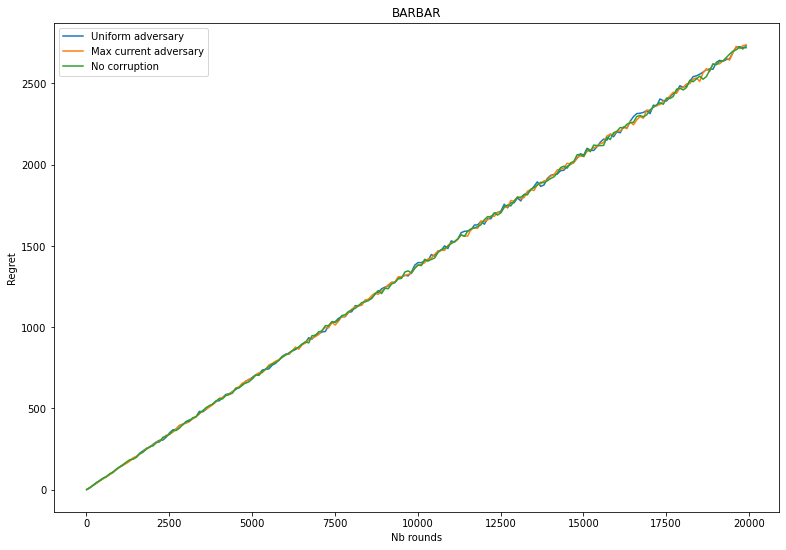

In [43]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_unif_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_max_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_no_corr)
plt.legend(['Uniform adversary', 'Max current adversary', 'No corruption'], 
           fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("BARBAR")

In [45]:
%%time

# Max Current adversary
# UCB player
# Uniform env
env = UnifEnv([.7, .4, .9, .5])
max_adversary = MaxCurrentAdv(corruption=.2, frequency=.7)
res_ucb_max_corr = list()

for i in np.arange(int(1e1), int(2e4), int(1e2)):
    player = UCBPlayer(env.n_arms)
    res = main_loop(env, player, max_adversary, i)
    res_ucb_max_corr.append(
        compute_strategy_regret(i,
                                res['all_actions'], 
                                env.arm_means))


CPU times: user 1min, sys: 611 ms, total: 1min 1s
Wall time: 1min 5s


Text(0.5, 1.0, 'UCB')

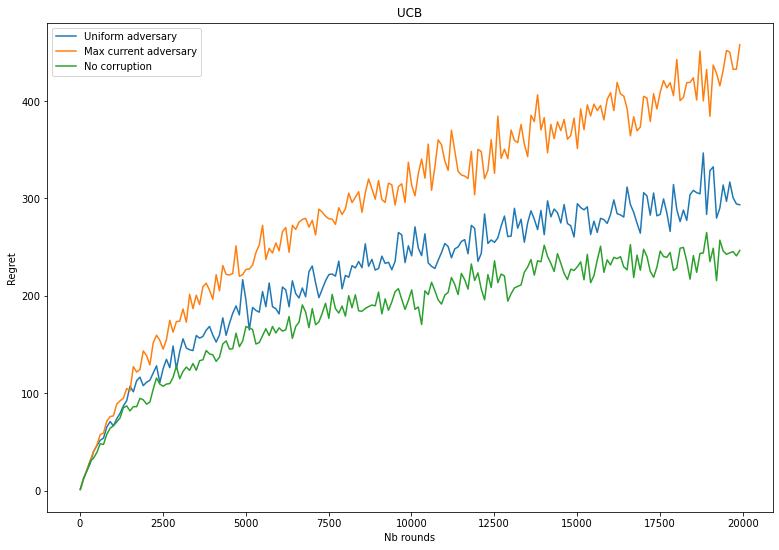

In [46]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_unif_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_max_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_no_corr)
plt.legend(['Uniform adversary', 'Max current adversary', 'No corruption'], 
           fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("UCB")

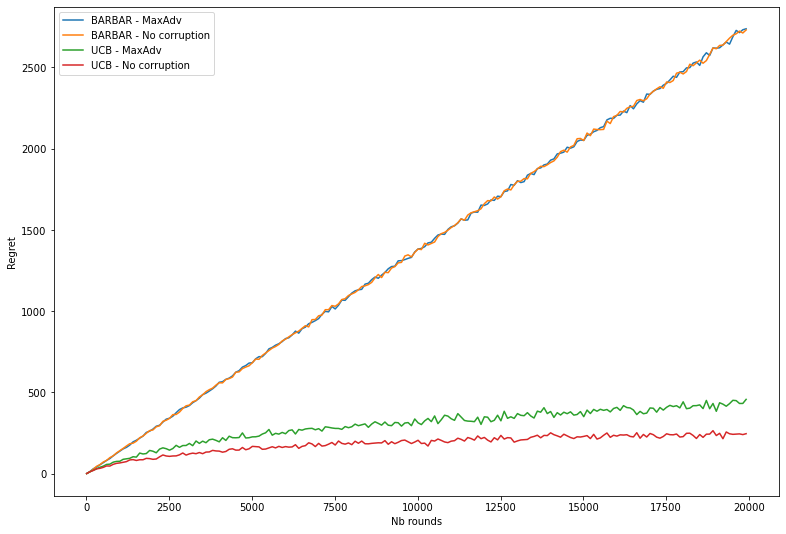

In [62]:
plt.figure(figsize=(13, 9))

plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_max_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_no_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_max_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_ucb_no_corr)
plt.legend(['BARBAR - MaxAdv', 'BARBAR - No corruption', 'UCB - MaxAdv', 'UCB - No corruption'], 
           fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
#plt.title()

plt.savefig('comparison.jpeg')
plt.show()

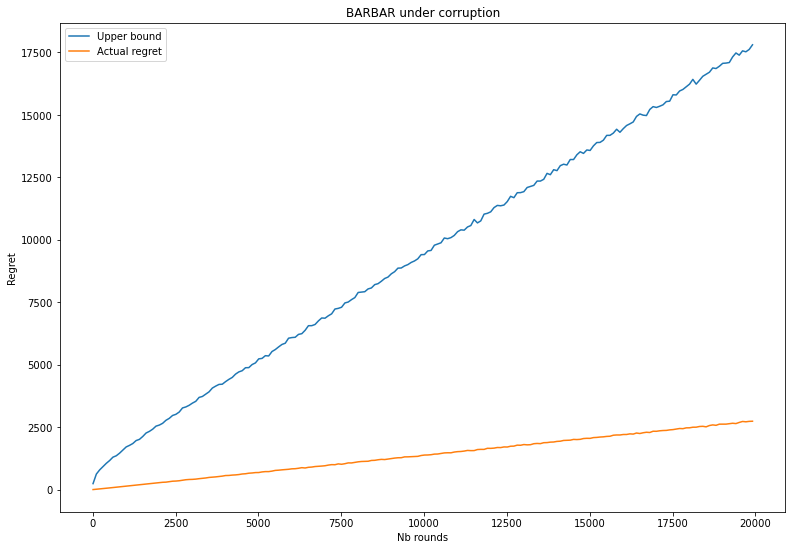

In [65]:
plt.figure(figsize=(13, 9))
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), bound_barbar_max_corr)
plt.plot(np.arange(int(1e1), int(2e4), int(1e2)), res_barbar_max_corr)
plt.legend(['Upper bound', 'Actual regret'], 
           fontsize=10)
plt.xlabel("Nb rounds")
plt.ylabel("Regret")
plt.title("BARBAR under corruption")
plt.savefig('barbar_bound.jpeg')
plt.show()

In [83]:
%%time
# analysis of immediate regret
nb_rounds = int(1e6)
env = UnifEnv([.7, .4, .9, .5])
print('Best arm is ', env.best_arm)
player_ucb = UCBPlayer(env.n_arms)
player_aae = AAEPlayer(env.n_arms, .05)
player_barbar = BARBARPlayer(env.n_arms, .05, nb_rounds)
adversary = MaxCurrentAdv(corruption=.3, frequency=.7)
res_ucb = main_loop(env, player_ucb, adversary, nb_rounds)
res_aae = main_loop(env, player_aae, adversary, nb_rounds)
res_barbar = main_loop(env, player_barbar, adversary, nb_rounds)

Best arm is  2
CPU times: user 1min 15s, sys: 256 ms, total: 1min 16s
Wall time: 1min 16s


In [84]:
regrets_ucb = compute_immediate_regrets(res_ucb['all_actions'], 
                                        res_ucb['all_true_rewards'], 
                                        env.arm_means[env.best_arm])
regrets_aae = compute_immediate_regrets(res_aae['all_actions'], 
                                        res_aae['all_true_rewards'], 
                                        env.arm_means[env.best_arm])
regrets_barbar = compute_immediate_regrets(res_barbar['all_actions'], 
                                           res_barbar['all_true_rewards'], 
                                           env.arm_means[env.best_arm])

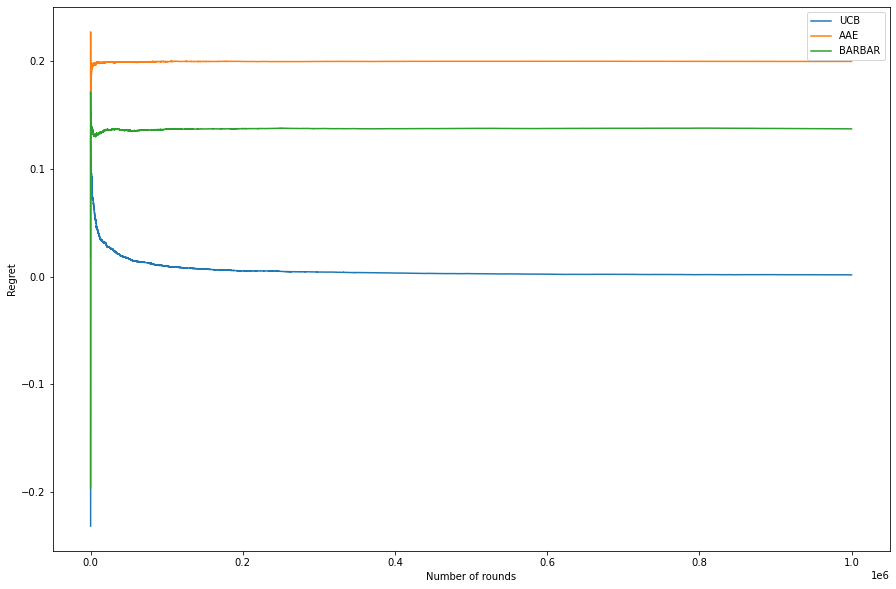

In [85]:
plot_immediate_regrets([regrets_ucb, regrets_aae, regrets_barbar], ['UCB', 'AAE', 'BARBAR'])
plt.savefig('immediate_regrets.jpeg')

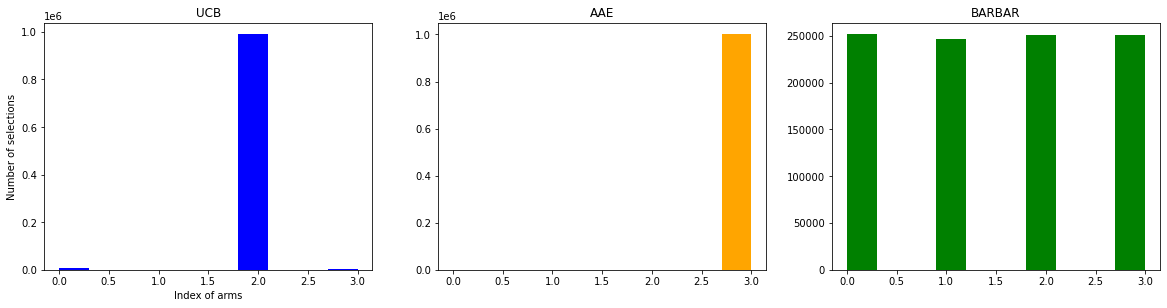

In [128]:
plt.figure(figsize=(20, 10))
#ax = plt.figure(figsize=(20, 10)).add_subplot(111, fr)

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)

ax1.hist(res_ucb['all_actions'], color='blue')
ax2.hist(res_aae['all_actions'], color='orange')
ax3.hist(res_barbar['all_actions'], color='green')

ax1.set_xlabel('Index of arms')
ax1.set_ylabel('Number of selections')

ax1.set_title("UCB")
ax2.set_title("AAE")
ax3.set_title("BARBAR")

plt.savefig('arms.jpeg')